In [90]:
#%load_ext lab_black

# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [91]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
import torchtext
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [92]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [93]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [94]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [95]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [96]:
word = "cat"
# your code

# find the most similar word to "cat" in the vocabulary
max_similarity = -1
most_similar_word = None
second_max_similarity = -1
second_most_similar_word = None
for w in glove.itos:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[word]].reshape(1, -1),
        glove.vectors[glove.stoi[w]].reshape(1, -1),
    ).item()
    if similarity > max_similarity:
        second_max_similarity = max_similarity
        second_most_similar_word = most_similar_word
        max_similarity = similarity
        most_similar_word = w

print(f"{word} x {most_similar_word} = {max_similarity}")
print(f"{word} x {second_most_similar_word} = {second_max_similarity}")


cat x cat = 1.0
cat x dog = 0.6816746592521667


## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [97]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [98]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [99]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    # Your code

    # tokenize the text
    tokens = tokenizer(text)
    # get the vectors of the tokens
    vectors = []
    for token in tokens:
        if token in vocabulary.stoi:
            vectors.append(vocabulary.vectors[vocabulary.stoi[token]])
    # average the vectors
    average = torch.mean(torch.stack(vectors), dim=0)
    return average

In [100]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [101]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [102]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    # yield the the returning values
    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i : i + batch_size]), torch.tensor(y[i : i + batch_size])


In [103]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [104]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        # your code
        super(SimpleClassifer, self).__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        # return sigmoid logits
        return torch.sigmoid(self.linear(x))
        

## Training (3 points)

We put everything above together and train the classifier.

In [105]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [106]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [107]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [108]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    # training loop
    x = train_gen()
    for X, y in x:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(torch.squeeze(output), y.float())
        loss.backward()
        optimizer.step()
    
    # validation
    model.eval()
    # validation loop
    if epoch % 5 == 0:
        with torch.no_grad():
            x = valid_gen()
            for X, y in x:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(torch.squeeze(output), y.float())
                valid_losses.append(loss.item())
            print(f"Epoch {epoch} - Validation loss: {np.mean(valid_losses)}")
            if np.mean(valid_losses) < best_validation_loss:
                best_model = model
                best_validation_loss = np.mean(valid_losses)

            # calculate the test loss
            x = test_gen()
            for X, y in x:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(torch.squeeze(output), y.float())
                train_losses.append(loss.item())
            print(f"        - Training loss: {np.mean(train_losses)}")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Validation loss: 0.6863723355493728
        - Training loss: 0.6867036356797913
Epoch 5 - Validation loss: 0.6671593952330814
        - Training loss: 0.667679578142093
Epoch 10 - Validation loss: 0.6553393073395812
        - Training loss: 0.6557642251939115
Epoch 15 - Validation loss: 0.6472763059435377
        - Training loss: 0.6474694829729511
Epoch 20 - Validation loss: 0.6413794380844019
        - Training loss: 0.6412736188877574
Epoch 25 - Validation loss: 0.636669742706728
        - Training loss: 0.6364127210859853
Epoch 30 - Validation loss: 0.6328194356702261
        - Training loss: 0.6324834972402237
Epoch 35 - Validation loss: 0.6295998203004621
        - Training loss: 0.6292236293273051
Epoch 40 - Validation loss: 0.6269393335271203
        - Training loss: 0.6264595858970804
Epoch 45 - Validation loss: 0.6246685161901887
        - Training loss: 0.6240778370548392


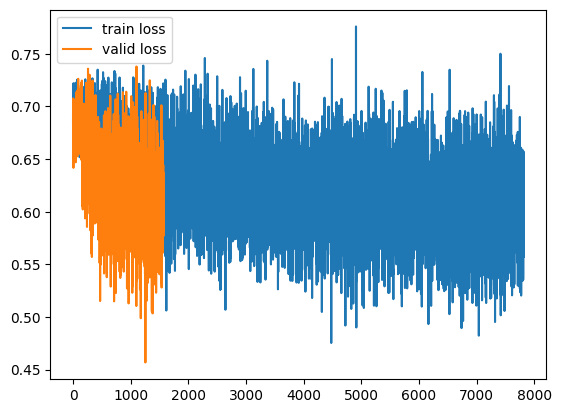

In [109]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [110]:
# Your code
# compute the accuracy on the 3 splits
def accuracy(model, X, y):
    with torch.no_grad():
        X = torch.stack(X).to(device)
        y = torch.tensor(y).to(device)
        output = model(X)
        output = torch.squeeze(output)
        output = torch.round(output)
        return torch.sum(output == y).item() / len(y)
    
print(f"Accuracy on the training set: {accuracy(model, X_train, y_train)}")
print(f"Accuracy on the validation set: {accuracy(model, X_valid, y_valid)}")
print(f"Accuracy on the test set: {accuracy(model, X_test, y_test)}")

Accuracy on the training set: 0.8041
Accuracy on the validation set: 0.7992
Accuracy on the test set: 0.79616


**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**

In [111]:
# take two wrong predictions
wrong_predictions = []
for i in range(len(X_test)):
    if torch.round(torch.squeeze(model(torch.stack(X_test).to(device))[i])) != y_test[i]:
        wrong_predictions.append(i)
        if len(wrong_predictions) == 2:
            break

# print the wrong predictions
for i in wrong_predictions:
    print(f"Text: {test_df['text'][i]}")
    print(f"Label: {test_df['label'][i]}")
    print(f"Prediction: {torch.round(torch.squeeze(model(torch.stack(X_test).to(device))[i]))}")

Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. In particular he has found a muse with Scott Adkins, as talented an actor and action performer as you could hope for. This is borne out with Special Forces and Undisputed 2, but unfortunately The Shepherd just doesn't live up to their abilities.<br /><br />There is no doubt that JCVD looks better here fight-wise than he has done in years, especially in the fight he has (for pretty much no reason) in a prison cell, and in the final showdown with Scott, but look in his eyes. JCVD seems to be dead inside. There's nothing in his eyes at all. It's like he just doesn't care about anything throughout the whole film. And 

# TODO : expliquer pk c'est des mauvaises predictions

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [112]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    # Your code
    tensor = text_pipeline(text).to(device)
    output = model(tensor)
    output = torch.squeeze(output)
    label = torch.round(output)
    return int(label), float(output.item())


In [113]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
#text = "it's the best movie ever, love it so much"
predict(text, text_pipeline, model, device)

(0, 0.21351926028728485)

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.